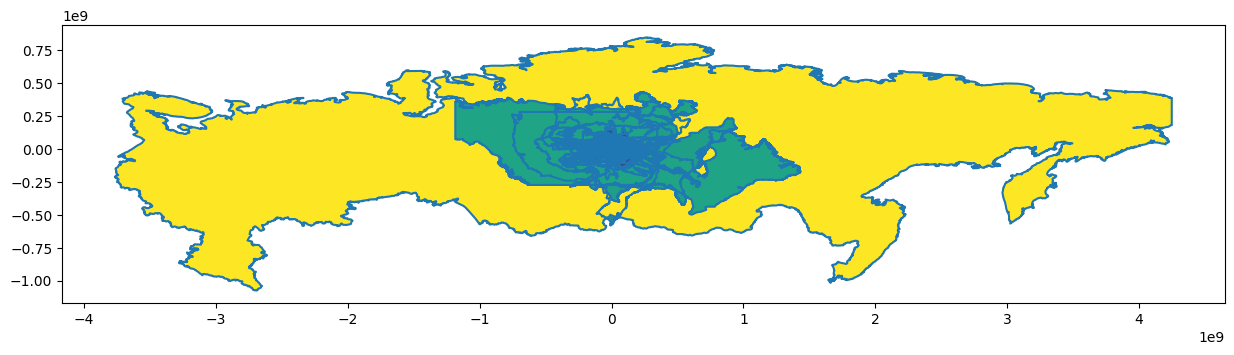

In [5]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
import csv
from shapely.geometry import MultiPolygon
from shapely.affinity import scale

# 从 natural_earth 读取shapefile数据
shpfilename = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

# 将数据转换为 GeoDataFrame
data = []
for country in countries:
    geometry = country.geometry
    name = country.attributes['SOVEREIGNT']
    data.append({'geometry': geometry, 'name': name})
world = gpd.GeoDataFrame(data, columns=['geometry', 'name'])

# 从 CSV 文件读取国家值
num = 16
country_values = {}
with open("G:\\Hangkai\\Forest_edge\\country_stats\\final_data\\processed_country_data.csv", 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader)
    for row in reader:
        value = float(row[num])
        if value != -1:  # Exclude countries with value -1
            country_values[row[0]] = value

# 对 GeoDataFrame 进行操作以根据你的数据调整形状
new_geometries = []
for country in world.itertuples():
    if country.name in country_values:
        factor = country_values[country.name]
        if isinstance(country.geometry, MultiPolygon):
            new_geo = MultiPolygon([scale(geom, xfact=factor, yfact=factor, origin='centroid') for geom in country.geometry.geoms])
        elif isinstance(country.geometry, Polygon):
            new_geo = scale(country.geometry, xfact=factor, yfact=factor, origin='centroid')
        new_geometries.append(new_geo)
    else:
        new_geometries.append(country.geometry)

world['geometry'] = new_geometries

# 从 natural_earth 读取shapefile数据
shpfilename = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)

# 根据 country_values 的值为每个国家上色
for country in world.itertuples():
    if country.name in country_values:
        value = country_values[country.name]
        color = plt.cm.trubo(value / max(country_values.values()))
        
        if country.geometry.geom_type == 'MultiPolygon':
            for polygon in country.geometry.geoms:
                ax.fill(*polygon.exterior.xy, color=color)
        else:
            ax.fill(*country.geometry.exterior.xy, color=color)

plt.axis('scaled')
plt.show()

C:\Users\hyou34\AppData\Local\Temp\ipykernel_15696\1182549355.py:46: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Polygon':


TypeError: 'MultiPolygon' object is not iterable

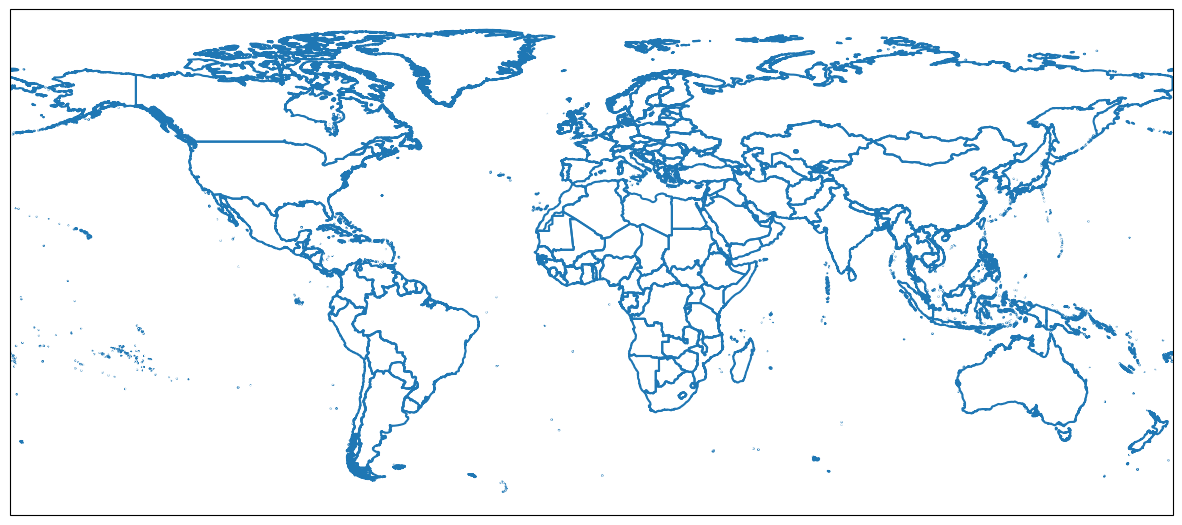

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# 从 natural_earth 读取shapefile数据
shpfilename = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

# 将数据转换为 GeoDataFrame
data = []
for country in countries:
    geometry = country.geometry
    name = country.attributes['SOVEREIGNT']
    data.append({'geometry': geometry, 'name': name})
world = gpd.GeoDataFrame(data, columns=['geometry', 'name'])

# 从 CSV 文件读取国家值
num = 16
country_values = {}
with open("G:\\Hangkai\\Forest_edge\\country_stats\\final_data\\processed_country_data.csv", 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader)
    for row in reader:
        value = float(row[num])
        if value != -1:  # Exclude countries with value -1
            country_values[row[0]] = value
# Merging the value to the GeoDataFrame
world['value'] = world['name'].map(country_values)

# Drop countries that didn't find a matching value
world = world.dropna()

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
world.boundary.plot(ax=ax)

# Iterating through each country to resize and plot
for index, country in world.iterrows():
    # Scaling factor, you might want to customize this
    scaling_factor = country['value'] * 0.1  
    
    geom = country['geometry']
    
    if geom.type == 'Polygon':
        geom = [geom]  # Make it iterable for consistency
    
    for polygon in geom:
        # Getting x and y coordinates of the country's geometry
        x, y = polygon.exterior.xy
        
        # Calculating the mean coordinates
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        
        # Modifying the coordinates by moving them closer/farther to the mean point
        x_modified = (x - x_mean) * scaling_factor + x_mean
        y_modified = (y - y_mean) * scaling_factor + y_mean
        
        # Plotting the modified country
        ax.fill(x_modified, y_modified)
        
plt.show()